# Использование машинного обучения для обнаружения вредоносных URL-адресов

## Загрузка имеющегося набора данных. Исследование и корректировка данных в наборе

In [2]:
import pandas as pd
import numpy as np
import numpy.random

In [3]:
filepath = "data.csv"
data = pd.read_csv(filepath, on_bad_lines='skip')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [5]:
data.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


Видим, что наш датасет состоит из двух столбцов: адрес и его классификация

In [6]:
data['label'].value_counts()

label
good    344821
bad      75643
Name: count, dtype: int64

Адреса делятся на два класса - хорошие и плохие

## Предобработка данных
Перемешаем имеющиеся данные

In [7]:
urls = np.array(data)
np.random.shuffle(urls)

In [8]:
X = urls[:, 0]
y = urls[:, 1]

Так как большая часть моделей машинного обучения, в том числе и логистическая регрессия, используемая нами, работают с **численными данными**, то нам необходимо преобразовать пароли в вектора чисел. Для этого, мы будем использовать **TfidfVectorizer** (Term Frequency-Inverse Document Frequency Vectorizer) - это инструмент для преобразования коллекции текстовых документов в матрицу TF-IDF. 
Так как, по умолчанию, TfidfVectorizer работает с текстами, и разбивает их на отдельные слова (каждый отдельный токен - слово), нам необходимо указать ему другой способ разбивки на токены, т.к. работаем не с текстами, а со словами. Реализуем функцию, разбивающее строку на токены.  
Примеры ссылок: 
* *"canpolitics.com/cprbr_index.html"*
* *"https://serpstat.com/ru/blog/novie-vozmozhnosti-iyunskie-obnovleniya-serpstat/"*
* *"https://www.amazon.com/s?i=specialty-aps&bbn=16225009011&rh=n%3A%2116225009011%2Cn%3A541966&ref=nav_em__nav_desktop_sa_intl_computers_and_accessories_0_2_21_6"*,
* *"kinsta.com/blog/what-is-a-url#the-anatomy-of-a-url"*

Подумаем о том, какие признаки в наших ссылках могут быть полезны при исследовании. Для начала, изучим строение URL ссылок.
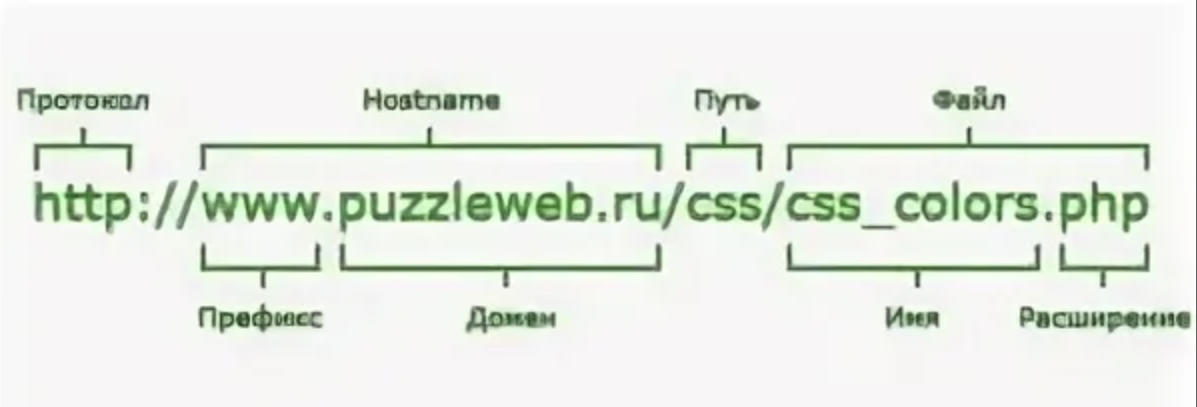
Видим, что для разделения ссылки на части используется '*/*'. Проведем первоначальное разбиение ссылки опираясь на '*/*'. Далее, рассмотрим части после разбиения. Например, стоит заметить, что префикс и домен, имя и расширения - находятся в одной части, отделенной с каждой стороны с помощью '*/*'. Было бы хорошо рассматривать подобные случаи не только вместе, но и разбивать их на отдельные признаки, поэтому, добавим в список признаков разбиение по *'.'* после разбиения по '*/*'. Опираясь на примеры видим, что отдельные слова отделяются друг от друга с помощью '*-*'. Например, часть ссылки, которая находится за знаком #, называется Якорнь. Это ссылка которая ведет на определенную часть страницы. Слова в ней разделяются с помощью '*-*'. Поэтому, после разбиения по '*/*' добавим не только разбиение по '*.*' , но и по '*-*' 

In [9]:
def getTokens(input):
	tokensBySlash = str(input.encode('utf-8')).split('/')	
	allTokens = []
	for i in tokensBySlash:
		tokens = str(i).split('-')	
		tokensByDot = []
		for j in range(0,len(tokens)):
			tempTokens = str(tokens[j]).split('.')	
			tokensByDot = tokensByDot + tempTokens
		allTokens = allTokens + tokens + tokensByDot
	allTokens = list(set(allTokens))	
	if 'com' in allTokens:
		allTokens.remove('com')
	return allTokens

Проведем описанное ранее преобразование наших данных, а также разобьем данные на тестовые и тренировочные.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
    
vectorizer = TfidfVectorizer(tokenizer=getTokens)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

/Users/Work/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Обучение модели и получение результатов
Обучаем модель логистической регрессии, после чего, выводим точность ее работы на тестовых данных

In [24]:
from sklearn import linear_model
lgs = linear_model.LogisticRegression(penalty='l2',multi_class='ovr')
lgs.fit(X_train, y_train)
print(lgs.score(X_test, y_test))

0.9611620467815395


Покажем работу нашей модели на практике:

In [25]:
X2_predict = ['https://www.worldbank.org/en/home','http://www.akham.ru/remove','http://www.sberbank.ru/','https://www.defense.gov/','https://ru.wikipedia.org/wiki/%D0%9C%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D0%B5%D1%80%D1%81%D1%82%D0%B2%D0%BE_%D0%BE%D0%B1%D0%BE%D1%80%D0%BE%D0%BD%D1%8B_%D0%A1%D0%A8%D0%90','https://rutor.info/']
X2_predict = vectorizer.transform(X2_predict)
y2_Predict = lgs.predict(X2_predict)
print(y2_Predict)

['good' 'bad' 'bad' 'good' 'good' 'bad']
